# cycleGAN

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils
from torch.nn.utils import spectral_norm
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os

from torch.utils.data import DataLoader
from ds import MIBIDataset
import torch.nn.utils.spectral_norm as spectral_norm

from utilities import weights_init, seg_show

In [2]:
normalize = matplotlib.colors.Normalize(vmin=0, vmax=1)

torch.cuda.set_device(0)
gpu_available = True
channel_names = ["Pan-Keratin", "EGFR", "Beta catenin", "dsDNA",
                 "Ki67", "CD3", "CD8", "CD4", "FoxP3", "MPO", "HLA-DR", 
                 "HLA_Class_1", "CD209", "CD11b",  "CD11c", "CD68", "CD63",
                 "Lag3", "PD1", "PD-L1", "IDO", "Vimentin", "SMA", "CD31"]

# Parameters

In [3]:
# Learning rate for optimizers
batch_size = 32
nz = hidden_size = 128
kernel = 3

# Number of input channels (later to be number of classes)
num_chan = 18

# Size of feature maps in discriminator
ndf = 32

# Output dimension
nc = 24

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

c24_idx = np.array(range(25))
c24_idx = np.delete(c24_idx, 4)

# Read In Data

In [ ]:
# train data
cells_seg = []
cells_real = []
keys = []

path = './data'
filelist = os.listdir(path + '/train')

for i in range(int(len(filelist[:]))): # have both counts and cells
    patch = path + '/train/cell_' + str(i) + '.npy'
    cells_seg.append(np.load(patch)[0])
    cells_real.append(np.load(patch)[1][c24_idx])

print('number of total cells: %d' % (len(cells_seg))) 

cells_seg = np.array(cells_seg)
empty = np.less(np.sum(cells_seg, axis=1, keepdims=True), 0.5).astype(np.float32)
cells_seg = np.concatenate([cells_seg, empty], axis=1)


cells_real = np.array(cells_real) 
cells = np.array([[cells_seg[i], cells_real[i]] for i in range(len(cells_seg))])

train_set_loader = DataLoader(MIBIDataset(cells), batch_size=batch_size, 
                       shuffle=True, num_workers=4, pin_memory=gpu_available)

In [ ]:
# test data

cells_seg = []
cells_real = []
keys = []

path = './data'
filelist = os.listdir(path + '/test')

for i in range(int(len(filelist[:]))): # have both counts and cells
    patch = path + '/test/cell_' + str(i) + '.npy'
    cells_seg.append(np.load(patch)[0])
    cells_real.append(np.load(patch)[1][c24_idx])

print('number of total cells: %d' % (len(cells_seg))) 


cells_seg = np.array(cells_seg)
empty = np.less(np.sum(cells_seg, axis=1, keepdims=True), 0.5).astype(np.float32)
cells_seg = np.concatenate([cells_seg, empty], axis=1)

cells_real = np.array(cells_real)
cells = np.array([[cells_seg[i], cells_real[i]] for i in range(len(cells_seg))])

test_set_loader =  DataLoader(MIBIDataset(cells), batch_size=1, 
                       shuffle=True, num_workers=4, pin_memory=gpu_available)


# Generator

In [5]:
class ResnetBlock(nn.Module):
    """Define a Resnet block"""

    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Initialize the Resnet block
        A resnet block is a conv block with skip connections
        We construct a conv block with build_conv_block function,
        and implement skip connections in <forward> function.
        Original Resnet paper: https://arxiv.org/pdf/1512.03385.pdf
        """
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Construct a convolutional block.
        Parameters:
            dim (int)           -- the number of channels in the conv layer.
            padding_type (str)  -- the name of padding layer: reflect | replicate | zero
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
            use_bias (bool)     -- if the conv layer uses bias or not
        Returns a conv block (with a conv layer, a normalization layer, and a non-linearity layer (ReLU))
        """
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim), nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        """Forward function (with skip connections)"""
        out = x + self.conv_block(x)  # add skip connections
        return out

In [6]:
class ResnetGenerator(nn.Module):
    """Resnet-based generator that consists of Resnet blocks between a few downsampling/upsampling operations.
    We adapt Torch code and idea from Justin Johnson's neural style transfer project(https://github.com/jcjohnson/fast-neural-style)
    """

    def __init__(self, input_nc, output_nc, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=4, padding_type='reflect'):
        """Construct a Resnet-based generator
        Parameters:
            input_nc (int)      -- the number of channels in input images
            output_nc (int)     -- the number of channels in output images
            ngf (int)           -- the number of filters in the last conv layer
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers
            n_blocks (int)      -- the number of ResNet blocks
            padding_type (str)  -- the name of padding layer in conv layers: reflect | replicate | zero
        """
        assert(n_blocks >= 0)
        super(ResnetGenerator, self).__init__()

        use_bias = norm_layer == nn.InstanceNorm2d

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=use_bias),
                 norm_layer(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):  # add downsampling layers
            mult = 2 ** i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=use_bias),
                      norm_layer(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2 ** n_downsampling
        for i in range(n_blocks):       # add ResNet blocks

            model += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]

        for i in range(n_downsampling):  # add upsampling layers
            mult = 2 ** (n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=use_bias),
                      norm_layer(int(ngf * mult / 2)),
                      nn.ReLU(True)]
        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Sigmoid()]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        """Standard forward"""
        return self.model(input)




In [8]:
# netG.encoder

# Discriminator

In [7]:
class DiscriminatorBase(nn.Module):
    def __init__(self,
                 ndf=ndf, 
                 num_chan=num_chan, 
                 batch_size=batch_size,
                 nz=nz,
                 nc=nc):
        super(DiscriminatorBase, self).__init__()

        self.layer1 = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(num_chan, ndf, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=False))
        
        self.layer2 = nn.Sequential(
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=False))
        
        self.layer3 = nn.Sequential(
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=False))
        
        self.layer4 = nn.Sequential(
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=False))
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(ndf * 8, ndf * 16, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=False))
            
        
        self.layer6 = nn.Sequential(
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 16, 1, kernel_size=3, stride=2, padding=1),
            nn.Sigmoid()
        )

        # self.feature_maps = []
        
    def forward(self, input):
        
        x = input
        
        x = self.layer1(x)
        # self.feature_maps.append(x)
        
        x = self.layer2(x)
        # self.feature_maps.append(x)
        
        x = self.layer3(x)
        # self.feature_maps.append(x)
        
        x = self.layer4(x)
        # self.feature_maps.append(x)
        
        x = self.layer5(x)
        # self.feature_maps.append(x)
        
        x = self.layer6(x)
        # self.feature_maps.append(x)
        
        return x


# Training Loop

In [11]:
# net A for generate real image
# net B for generate segmentation

netG_A = ResnetGenerator(18,24,6).float().cuda()
netG_B = ResnetGenerator(24,18,6).float().cuda()
netD_A = DiscriminatorBase(num_chan=24).float().cuda()
netD_B = DiscriminatorBase(num_chan=18).float().cuda()

optimizerG_A = optim.Adam(netG_A.parameters(), lr=0.0002)
optimizerD_A = optim.Adam(netD_A.parameters(), lr=0.0002)

optimizerG_B = optim.Adam(netG_B.parameters(), lr=0.0002)
optimizerD_B = optim.Adam(netD_B.parameters(), lr=0.0002)


netG_A.apply(weights_init)
netD_A.apply(weights_init)
netG_B.apply(weights_init)
netD_B.apply(weights_init)

# Initialize loss functions
criterionG = nn.MSELoss()
criterionD = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

print("Initialized")

Initialized


/home/ubuntu/MIBI/full/utilities.py:18: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight.data)


In [ ]:
# Training Loop
num_epochs = 120

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
R_losses = []
iters = 0

d_iters = 1
g_iters = 1

print("Starting Training Loop...")
# For each epoch
for epoch in range(1, num_epochs):
    if epoch % 100 == 0:
        for param_group in optimizerG_A.param_groups:
                param_group['lr'] /= 2
        for param_group in optimizerD_A.param_groups:
                param_group['lr'] /= 2
        for param_group in optimizerG_B.param_groups:
                param_group['lr'] /= 2
        for param_group in optimizerD_B.param_groups:
                param_group['lr'] /= 2        
                
    for idx, data in enumerate(train_set_loader):
        
        X_seg, X_real = data
        X_seg = torch.clamp(X_seg.transpose(2,1), 0, 1).float().cuda()
        X_real = X_real.transpose(2,1).float().cuda()

        
        ## Train with all-real batch
        for _ in range(d_iters):
            netD_A.zero_grad()
            netD_B.zero_grad()
            
            output_A = netD_A(X_real)
            output_B = netD_B(X_seg)
            label = torch.full(output_A.size(), real_label).cuda()
            
            errD_real = criterionD(output_A, label) + criterionD(output_B, label)
            errD_real.backward()
            
            D_x = (output_A + output_B).mean().item() / 2.0
            
            # noise = 0.5 * torch.randn(X_seg.size()[0], 128).cuda()
            fake_A = netG_A(X_seg)     # from seg to real
            fake_B = netG_B(X_real)     # from real to seg
            
            label.fill_(fake_label)
            output_A = netD_A(fake_A.detach())    # reral
            output_B = netD_B(fake_B.detach())    # seg
            
            
            errD_fake = criterionD(output_A, label) + criterionD(output_B, label)
            errD_fake.backward()
            
            D_G_z1 = (output_A + output_B).mean().item() / 2.0

            errD = errD_real + errD_fake 
            
            optimizerD_A.step()
            optimizerD_B.step()
        
            netD_A.zero_grad()
            netD_B.zero_grad()
            
        for _ in range(g_iters):
            netG_A.zero_grad()
            netG_B.zero_grad()
            
            fake_A = netG_A(X_seg)   # real
            fake_B = netG_B(X_real)  # seg
            label.fill_(real_label)
            
            output_A = netD_A(fake_A)    # real
            output_B = netD_B(fake_B)    # seg
            errG = criterionD(output_A, label) + criterionD(output_B, label)

            cycle_loss = 0
            # fake A is real data, netG_B(fake_A) is segmentation
            cycle_loss += nn.L1Loss()(netG_B(fake_A), X_seg) 
            # fake B is seg data, netG_A(fake_B) is real
            cycle_loss += nn.L1Loss()(netG_A(fake_B), X_real) # L1 loss for seg
            
            labmda = 10
            errG += labmda * cycle_loss
            
            errG.backward()
            D_G_z2 = (output_A + output_B).mean().item() / 2.0
            
            optimizerG_A.step()
            optimizerG_B.step()
            
        if idx % 10 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tLoss_R: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, idx, len(train_set_loader),
                     errD.item(), errG.item(), cycle_loss.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        
    if epoch % 5 == 1:

        fig=plt.figure(figsize=(2.5, 2.5))
        print("Segmentation: ")
        plt.imshow(seg_show(X_seg.detach().cpu().numpy()[0]))
        plt.show()
        
        fig=plt.figure(figsize=(16, 10))
        columns = 7
        rows = 4
        print("Fake: ")
        for i in range(24):
            fig.add_subplot(rows, columns, i+1)
            plt.title(channel_names[i])
            plt.imshow(fake_A.detach().cpu().numpy()[0][i],cmap='hot', interpolation='nearest')
        plt.show()
        
        
        fig=plt.figure(figsize=(16, 10))
        columns = 7
        rows = 4
        print("Real: ")
        for i in range(24):
            fig.add_subplot(rows, columns, i+1)
            plt.title(channel_names[i])
            plt.imshow( X_real[0,i,:,:].detach().cpu().numpy(),cmap='hot', interpolation='nearest')
        plt.show()
        
        
        fig=plt.figure(figsize=(16, 10))
        columns = 7
        rows = 4
        print("Scaled Fake: ")
        for i in range(24):
            fig.add_subplot(rows, columns, i+1)
            plt.title(channel_names[i])
            plt.imshow(fake_A.detach().cpu().numpy()[0][i],cmap='hot', interpolation='nearest', norm=normalize)
        plt.show()
        
        
        fig=plt.figure(figsize=(16, 10))
        columns = 7
        rows = 4
        print("Scaled Real: ")
        for i in range(24):
            fig.add_subplot(rows, columns, i+1)
            plt.title(channel_names[i])
            plt.imshow(X_real[0,i,:,:].detach().cpu().numpy(),cmap='hot', interpolation='nearest', norm=normalize)
        plt.show()
        
        
        
    if epoch % 20 == 1:
        print("============================")
        print("test cell")
        print("============================")
        
        for idx, data in enumerate(test_set_loader):
        
            X_seg, X_real = data
            X_seg = torch.clamp(X_seg.transpose(2,1), 0, 1).float().cuda()
            X_real = X_real.transpose(2,1).float().cuda()
            
            break
        
        
        fake_A = netG_A(X_seg.detach())
            
        fig=plt.figure(figsize=(2.5, 2.5))
        print("Segmentation: ")
        plt.imshow(seg_show(X_seg.detach().cpu().numpy()[0]))
        plt.show()
        
        fig=plt.figure(figsize=(16, 10))
        columns = 7
        rows = 4
        print("Fake: ")
        for i in range(24):
            fig.add_subplot(rows, columns, i+1)
            plt.title(channel_names[i])
            plt.imshow(fake_A.detach().cpu().numpy()[0][i],cmap='hot', interpolation='nearest')
        plt.show()
        
        
        fig=plt.figure(figsize=(16, 10))
        columns = 7
        rows = 4
        print("Real: ")
        for i in range(24):
            fig.add_subplot(rows, columns, i+1)
            plt.title(channel_names[i])
            plt.imshow(X_real[0,i,:,:].detach().cpu().numpy(),cmap='hot', interpolation='nearest')
        plt.show()
        
        
        fig=plt.figure(figsize=(16, 10))
        columns = 7
        rows = 4
        print("Scaled Fake: ")
        for i in range(24):
            fig.add_subplot(rows, columns, i+1)
            plt.title(channel_names[i])
            plt.imshow(fake_A.detach().cpu().numpy()[0][i],cmap='hot', interpolation='nearest', norm=normalize)
        plt.show()
        
        
        fig=plt.figure(figsize=(16, 10))
        columns = 7
        rows = 4
        print("Scaled Real: ")
        for i in range(24):
            fig.add_subplot(rows, columns, i+1)
            plt.title(channel_names[i])
            plt.imshow(X_real[0,i,:,:].detach().cpu().numpy(),cmap='hot', interpolation='nearest', norm=normalize)
        plt.show()


# Save & Load Model

In [15]:
state = {
    'epoch': epoch,
    'G': netG_A.state_dict(),
    'optimizerG': optimizerG_A.state_dict(),
    'D' : netD_A.state_dict(),
    'optimizerD' : optimizerD_A.state_dict()
}
torch.save(state, './model/baseline_cycleGAN')

In [8]:
netG_A = ResnetGenerator(18,24,6).float().cuda()
state = torch.load('./model/baseline_cycleGAN')
netG_A.load_state_dict(state['G'])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

# Reconstruction Metrics

# Adjusted L1

In [19]:
# Adjust L1

Loss = 0
AdjLoss  = 0
for idx, data in enumerate(test_set_loader):

    X_seg, X_real = data
    X_seg = torch.clamp(X_seg.transpose(2,1), 0, 1).float().cuda()
    X_real = X_real.transpose(2,1).float().cuda()
    X_mask = (1 - X_seg[:,-1]).unsqueeze(1)
    noise = 0.5 * torch.randn(X_seg.size()[0], 128).cuda()
    fake = netG_A(X_seg).detach()
    outside = (1 - X_mask) * fake
    
    B,C = X_real.size()[:2]
    real_data = (X_mask*X_real).view(B, C, -1)
    fake_data = (X_mask*fake).view(B, C, -1)
    # print(real_data.shape)
    
    real_rank, _ = torch.sort(real_data, dim=2)
    fake_rank, _ = torch.sort(fake_data, dim=2)
    
    Loss += nn.L1Loss()(real_rank[:], fake_rank[:])
    AdjLoss += nn.L1Loss()(real_rank[:], fake_rank[:])
    AdjLoss += nn.L1Loss()(outside[:], torch.zeros_like(outside[:]))
    
print('Adjust L1 Metric:', AdjLoss.item())
print('Pure L1 Metric:', Loss.item())

Adjust L1 Metric: 4.74533748626709
Pure L1 Metric: 3.959035873413086


# Adjusted MSE

In [20]:
# Adjust MSE

Loss = 0
AdjLoss  = 0
for idx, data in enumerate(test_set_loader):

    X_seg, X_real = data
    X_seg = torch.clamp(X_seg.transpose(2,1), 0, 1).float().cuda()
    X_real = X_real.transpose(2,1).float().cuda()
    X_mask = (1 - X_seg[:,-1]).unsqueeze(1)
    noise = 0.5 * torch.randn(X_seg.size()[0], 128).cuda()
    fake = netG_A(X_seg).detach()
    outside = (1 - X_mask) * fake
    
    B,C = X_real.size()[:2]
    real_data = (X_mask*X_real).view(B, C, -1)
    fake_data = (X_mask*fake).view(B, C, -1)
    # print(real_data.shape)
    
    real_rank, _ = torch.sort(real_data, dim=2)
    fake_rank, _ = torch.sort(fake_data, dim=2)
    
    Loss += nn.MSELoss()(real_rank[:], fake_rank[:])
    AdjLoss += nn.MSELoss()(real_rank[:], fake_rank[:])
    AdjLoss += nn.MSELoss()(outside[:], torch.zeros_like(outside[:]))
    
print('Adjust MSE Metric:', AdjLoss.item())
print('Pure MSE Metric:', Loss.item())

Adjust L1 Metric: 1.8410778045654297
Pure L1 Metric: 1.5232505798339844


# SSIM

In [10]:
cells_seg_list = []
cells_real_list = []

download_path = './data/benchmark_p14'
filelist = os.listdir(download_path)

for i in range(len(filelist)):
    patch = download_path + '/cell_' + str(i) + '.npy'
    cells_seg_list.append(np.load(patch)[0])
    cells_real_list.append(np.load(patch)[1])

In [23]:
from skimage.measure import compare_ssim

ssim_score = 0
ssim_channels = np.zeros(nc)

for c in range(len(cells_seg_list)):
    
    seg_list = cells_seg_list[c]
    real_list = cells_real_list[c]
    n_cell = len(seg_list)
    noise = 0.5 * torch.randn(1, 128).cuda()
    
    # seg_test = 0
    seg_test = np.sum(seg_list, axis=0)
    empty = np.less(np.sum(seg_test, axis=0, keepdims=True), 0.5).astype(np.float32)
    seg_test_18 = np.concatenate([seg_test, empty], axis=0)
    X_seg_0 = torch.Tensor(seg_test_18).unsqueeze(0).cuda()
    
    # fake = netG(noise, X_seg_0).detach().cpu().numpy()[0]
    fake = netG_A(X_seg_0).detach().cpu().numpy()[0]
    
    # fake = netF(fake, X_seg_0)
    for j in range(nc):
        fake_i = fake[j].astype(float)
        real_i = np.sum(real_list, axis=0)[j].astype(float)  # i-th cell, j-th channel

        # plt.imshow(fake_i)
        # plt.show()
        # plt.imshow(real_i)
        # plt.show()
        ssim_score += compare_ssim(fake_i, real_i)/nc
        ssim_channels[j] += compare_ssim(fake_i, real_i)

print('ssim score:', ssim_score/len(cells_seg_list))
for j in range(nc):
    print(channel_names[j], ssim_channels[j]/len(cells_seg_list))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


ssim score: 0.8809145165387516
Pan-Keratin 0.8187361092156094
EGFR 0.9972809569975479
Beta catenin 0.5168599206550522
dsDNA 0.4973884389850895
Ki67 0.9615287057821243
CD3 0.9427756681144835
CD8 0.9729569181960426
CD4 0.9771394589641068
FoxP3 0.9999999999999999
MPO 0.9990111463146572
HLA-DR 0.9022520843371044
HLA_Class_1 0.2968819965200382
CD209 0.9999999999999988
CD11b 0.9895177895380284
CD11c 0.9885190539072409
CD68 0.9342855798832719
CD63 0.981329827318071
Lag3 0.9993878485578126
PD1 0.9849182412554274
PD-L1 0.6718834235438924
IDO 0.9999279896906733
Vimentin 0.7552882784345101
SMA 0.9544897746071103
CD31 0.9995891861116765


# Cell Based MI

In [12]:
def mutual_information(hgram):
    """ Mutual information for joint histogram
    """
    # Convert bins counts to probability values
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis=1) # marginal for x over y
    py = np.sum(pxy, axis=0) # marginal for y over x
    px_py = px[:, None] * py[None, :] # Broadcast to multiply marginals
    # Now we can do the calculation using the pxy, px_py 2D arrays
    nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

In [13]:
total_mi = 0
n_bin = 50
mi_channels = np.zeros(nc)

for c in range(len(cells_seg_list)):
    
    seg_list = cells_seg_list[c]
    real_list = cells_real_list[c]
    n_cell = len(seg_list)
    noise = 0.5 * torch.randn(1, 128).cuda()
    
    # seg_test = 0
    seg_test = np.sum(seg_list, axis=0)
    empty = np.less(np.sum(seg_test, axis=0, keepdims=True), 0.5).astype(np.float32)
    seg_test_18 = np.concatenate([seg_test, empty], axis=0)
    X_seg_0 = torch.Tensor(seg_test_18).unsqueeze(0).cuda()
    
    fake = netG_A(X_seg_0).detach().cpu().numpy()[0]
    
    for i in range(n_cell):
        mask = seg_list[i].sum(axis=0)
        
        for j in range(nc):
            fake_i = (fake*mask)[j].flatten()
            real_i = real_list[i][j].flatten()   # i-th cell, j-th channel

            hist_2d, _, _ = np.histogram2d(fake_i, real_i, bins=n_bin)

            mi = mutual_information(hist_2d)
            mi_channels[j] += mi/n_cell/nc
            total_mi += mi/n_cell/nc
            
print('mutual information:', total_mi)
for j in range(nc):
    print(channel_names[j], mi_channels[j])

mutual information: 7.962268725455467
Pan-Keratin 0.09598728365886473
EGFR 0.0004033814936930686
Beta catenin 0.21764999351860212
dsDNA 4.532185998505819
Ki67 0.0027855140136655433
CD3 0.006730639724491686
CD8 0.01842877363891995
CD4 0.0003351307202396081
FoxP3 0.0
MPO 0.00014223763035030648
HLA-DR 0.047998670974978355
HLA_Class_1 2.9357379081836465
CD209 0.0
CD11b 0.0
CD11c 0.0014969859348597653
CD68 0.004467774200231014
CD63 0.0022695621196041522
Lag3 0.0003805918689853457
PD1 0.003701402192228282
PD-L1 0.010546187327635147
IDO 6.15683278729268e-05
Vimentin 0.06562881497626911
SMA 0.015199585719006098
CD31 0.00013072072545850544


# Biological Significance

# Center of Mass

In [9]:
cells_seg_list = []
cells_real_list = []

download_path = './data/cd8_test_c24'
filelist = os.listdir(download_path)

for i in range(len(filelist)):
    patch = download_path + '/cell_' + str(i) + '.npy'
    cells_seg_list.append(np.load(patch)[0])
    cells_real_list.append(np.load(patch)[1])

In [27]:
cm_score = 0

for c in range(len(cells_seg_list)):
    
    seg_list = cells_seg_list[c]
    real_list = cells_real_list[c]
    n_cell = len(seg_list)
    xy = np.mgrid[0:64,0:64]
    noise = 0.5 * torch.randn(1, 128).cuda()
    
    # seg_test = 0
    seg_test = np.sum(seg_list, axis=0)
    empty = np.less(np.sum(seg_test, axis=0, keepdims=True), 0.5).astype(np.float32)
    seg_test_18 = np.concatenate([seg_test, empty], axis=0)
    X_seg_0 = torch.Tensor(seg_test_18).unsqueeze(0).cuda()
    
    
    fake = netG_A(X_seg_0).detach().cpu().numpy()[0]
        
    fake_tcell = fake * seg_list[0].sum(axis=0)    # only consider the expression in T cells
    fake_tumor = fake * (seg_test-seg_list[0]).sum(axis=0)    # only consider the expression in tumor cells

    cm_tumor_y = (xy[0]*fake_tumor).sum(axis=(1,2)) / (fake_tumor.sum(axis=(1,2))+1e-15)
    cm_tumor_x = (xy[1]*fake_tumor).sum(axis=(1,2)) / (fake_tumor.sum(axis=(1,2))+1e-15)
    cm_tumor = np.array([cm_tumor_x, cm_tumor_y])
    
    tcell_mask = seg_list[0].sum(axis=0)
    tcell_seg = np.array(np.where(tcell_mask==1))
    dist = np.linalg.norm(tcell_seg - cm_tumor[:, 19:20], axis=0)
    cm_idx = np.argmin(dist)
    cm_tumor_incell = tcell_seg[:, cm_idx]
    
    cm_tcell_y = (xy[0]*fake_tcell).sum(axis=(1,2)) / (fake_tcell.sum(axis=(1,2))+1e-15)
    cm_tcell_x = (xy[1]*fake_tcell).sum(axis=(1,2)) / (fake_tcell.sum(axis=(1,2))+1e-15)
    cm_tcell = np.array([cm_tcell_x, cm_tcell_y])

    
    cm_score += np.linalg.norm(cm_tcell[:,18] - cm_tumor_incell[:], ord=2)
    # cm_score += np.linalg.norm(cm_tcell[:,19] - cm_tumor[:,20], ord=2)
    
print('center of mass score:', cm_score / len(cells_seg_list))

center of mass score: 13.38275225931152


# EMD Score

In [12]:
from scipy.stats import wasserstein_distance

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    if phi < 0:
        phi = 2*np.pi + phi
        
    return (rho, phi)


def compute_histogram(img, divider=30, size = 64, offset=32):

    histogram = np.zeros([divider])

    for i in range(size):
        for j in range(size):
            x = j - offset
            y = offset - i
            
            rho, phi = cart2pol(x,y)
            # normalize to [0,divider]
            degree = divider * phi/(2*np.pi) 
            index = int(np.floor(degree))
            histogram[index] += img[i,j]
            
    return histogram

In [14]:
# EM score threshold
em_score = 0
direct_right = 0
direct_wrong = 0
direct_all = 0

for c in range(len(cells_seg_list)):

    
    seg_list = cells_seg_list[c]
    real_list = cells_real_list[c]
    n_cell = len(seg_list)
    noise = 0.5 * torch.randn(1, 128).cuda()
    
    seg_test = 0
    xy = np.mgrid[0:64,0:64]
    centroids_seg = []
    centroids_tcell = []
    centroids_tumor = []
    express_tcell = []
    for i in range(n_cell):

        # non-weighted centroid of segmentation
        cy = np.where(seg_list[i]==1)[1].mean()
        cx = np.where(seg_list[i]==1)[2].mean()
        centroids_seg.append(np.array([cx, cy]))

        # weighted centroid of T cells
        seg_test += seg_list[i]
        empty = np.less(np.sum(seg_test, axis=0, keepdims=True), 0.5).astype(np.float32)
        seg_test_18 = np.concatenate([seg_test, empty], axis=0)
        X_seg_0 = torch.Tensor(seg_test_18).unsqueeze(0).cuda()
        
        fake = netG_A(X_seg_0).detach().cpu().numpy()[0]
        
        fake_tcell = fake * seg_list[0].sum(axis=0)    # only consider the expression in T cells
        fake_tumor = fake * seg_list[i].sum(axis=0)    # only consider the expression in tumor cells
        # fake_tumor = fake * (seg_test-seg_list[0]).sum(axis=0)
        histo_cur = compute_histogram(fake_tcell[18])
        
        # weighted centroid of T cells
        cy_all = (xy[0]*fake_tcell).sum(axis=(1,2)) / (fake_tcell.sum(axis=(1,2))+1e-15)
        cx_all = (xy[1]*fake_tcell).sum(axis=(1,2)) / (fake_tcell.sum(axis=(1,2))+1e-15)
        centroids_tcell.append(np.array([cx_all, cy_all]))

        
        # weighted centroid of tumor cells
        cy_all = (xy[0]*fake_tumor).sum(axis=(1,2)) / (fake_tumor.sum(axis=(1,2))+1e-15)
        cx_all = (xy[1]*fake_tumor).sum(axis=(1,2)) / (fake_tumor.sum(axis=(1,2))+1e-15)
        centroids_tumor.append(np.array([cx_all, cy_all]))
        
        # print(fake_tumor[19].sum())
        
        if i > 0 and fake_tumor[19].sum() > 1e-4:
            
            direct_all += 1
            # the previous angle
            
            v1 = (centroids_tumor[i][:,19] - centroids_seg[0])    # previous centroid of T cell            
            v2 = (centroids_tcell[i][:,18] - centroids_tcell[i-1][:,18])    # current centroid of T cell
            
            if i == 1: # no work so much
                v2 = (centroids_tcell[i][:,18] - centroids_seg[0])
                
            cos_theta = np.dot(v1,v2)/np.linalg.norm(v1)/np.linalg.norm(v2)
            
            em_dist = wasserstein_distance(histo_cur, histo_pre)
            
            
            if cos_theta > 0:
                direct_right += 1
                
            elif cos_theta < 0:
                direct_wrong += 1
                
            if cos_theta > 0 and histo_cur.sum() > histo_pre.sum():   # threshold the theta / check the expression level
                em_score += np.linalg.norm(v2) * em_dist
                
            elif cos_theta < 0:
                em_score -= np.linalg.norm(v2) * em_dist
        
        histo_pre = histo_cur.copy()  
        
print("Direction: right:{}, wrong:{}, total:{}".format(direct_right, direct_wrong, direct_all))

print("em_score:{}".format(em_score))

Direction: right:643, wrong:810, total:1453
em_score:-0.014658566962307237


# Pan-Keratin / CD8 Experiment

In [10]:
# CD8 Test
noise = 0.5 * torch.randn(1, 128).cuda()
total = 0
decrease = 0


surface_area = []
tumor_expression = []

for c in range(len(cells_seg_list)):
    seg_list = cells_seg_list[c]
    real_list = cells_real_list[c]
    n_cell = len(seg_list)
    

    for k in range(1, n_cell):
    
        seg_tumor = np.sum(seg_list[0], axis=0)
        seg_test = np.zeros([17, 64, 64])
        seg_test[4] = seg_tumor    # tumor
        
        seg_cd8 = 0
        if k == 0:
            seg_test[7] =  0   # cd8
        else:
            seg_cd8 = np.sum(seg_list[1:k+1], axis=0).sum(0)
            seg_test[7] = seg_cd8    # cd8

        empty = np.less(np.sum(seg_test, axis=0, keepdims=True), 0.5).astype(np.float32)
        seg_test_18 = np.concatenate([seg_test, empty], axis=0)
        X_seg_0 = torch.Tensor(seg_test_18).unsqueeze(0).cuda()

        fake = netG_A(X_seg_0).detach().cpu().numpy()[0]
        
        pk_cur = (fake[0]*seg_tumor).sum()/ seg_tumor.sum()
 
        surface_area.append(seg_cd8.sum())
        tumor_expression.append(pk_cur)
   #  print(surface_area)#

slope: 3.2714532322573592e-06
r-square 0.12054332487326173
t-test 14.27163608480445
p-value 2.1111452592844882e-43


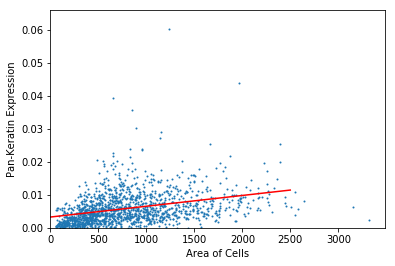

In [12]:
x = np.array(surface_area)
y = np.array(tumor_expression)

plt.xlabel('Area of Cells')
plt.ylabel('Pan-Keratin Expression')
plt.scatter(x,y,s=1)


from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(x,y)
t = np.arange(0,2500)
y_t = slope*t + intercept


t_test = r_value*np.sqrt(x.shape[0]-2)/np.sqrt(1-r_value**2)
plt.plot(t,y_t,'r')
print('slope:', slope)
print('r-square', r_value**2)
print('t-test', t_test)
print('p-value', p_value)
plt.xlim(0)
plt.ylim(0)
plt.show()

In [13]:
# CD8 Test: Tumor Controll
noise = 0.5 * torch.randn(1, 128).cuda()
total = 0
decrease = 0


surface_area = []
tumor_expression = []

for c in range(len(cells_seg_list)):
    seg_list = cells_seg_list[c]
    real_list = cells_real_list[c]
    n_cell = len(seg_list)
    
    for k in range(1, n_cell):
    
        seg_tumor = np.sum(seg_list[0], axis=0)
        seg_test = np.zeros([17, 64, 64])
        seg_test[4] = seg_tumor    # tumor
        
        seg_cd3 = 0
        if k>0:
            seg_cd3 = np.sum(seg_list[1:k+1], axis=0).sum(0)
            seg_test[4] += seg_cd3    # cd8
        
        
        empty = np.less(np.sum(seg_test, axis=0, keepdims=True), 0.5).astype(np.float32)
        seg_test_18 = np.concatenate([seg_test, empty], axis=0)
        X_seg_0 = torch.Tensor(seg_test_18).unsqueeze(0).cuda()

        fake = netG_A(X_seg_0).detach().cpu().numpy()[0]
        
        pk_cur = (fake[0]*seg_tumor).sum() / seg_tumor.sum()
 
        surface_area.append(seg_cd3.sum())
        tumor_expression.append(pk_cur)
        

slope: 2.2724450590605803e-06
r-square 0.028447061906126895
t-test 6.596216156134398
p-value 5.84753713392044e-11


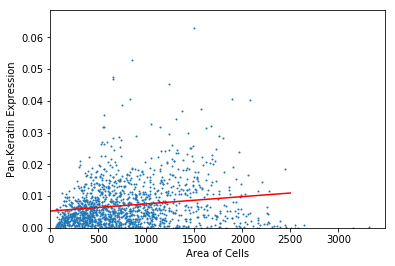

In [14]:
x = np.array(surface_area)
y = np.array(tumor_expression)

plt.xlabel('Area of Cells')
plt.ylabel('Pan-Keratin Expression')
plt.scatter(x,y,s=1)


from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(x,y)
t = np.arange(0,2500)
y_t = slope*t + intercept


t_test = r_value*np.sqrt(x.shape[0]-2)/np.sqrt(1-r_value**2)
plt.plot(t,y_t,'r')
print('slope:', slope)
print('r-square', r_value**2)
print('t-test', t_test)
print('p-value', p_value)
plt.xlim(0)
plt.ylim(0)
plt.show()

In [14]:
# CD8 Test
noise = 0.5 * torch.randn(1, 128).cuda()
total = 0
decrease = 0


cell_num = []
tumor_expression = []

for c in range(len(cells_seg_list)):
    seg_list = cells_seg_list[c]
    real_list = cells_real_list[c]
    n_cell = len(seg_list)
    
    for k in range(1, n_cell):
    
        seg_tumor = np.sum(seg_list[0], axis=0)
        seg_test = np.zeros([17, 64, 64])
        seg_test[4] = seg_tumor    # tumor
        
        
        if k == 0:
            seg_test[7] =  0   # cd8
        else:
            seg_cd3 = np.sum(seg_list[1:k+1], axis=0).sum(0)
            seg_test[7] = seg_cd3    # cd8

        
        empty = np.less(np.sum(seg_test, axis=0, keepdims=True), 0.5).astype(np.float32)
        seg_test_18 = np.concatenate([seg_test, empty], axis=0)
        X_seg_0 = torch.Tensor(seg_test_18).unsqueeze(0).cuda()

        fake = netG_A(X_seg_0).detach().cpu().numpy()[0]
        
        pk_cur = (fake[0]*seg_tumor).sum() / seg_tumor.sum()
        
        cell_num.append(k)
        tumor_expression.append(pk_cur)
        

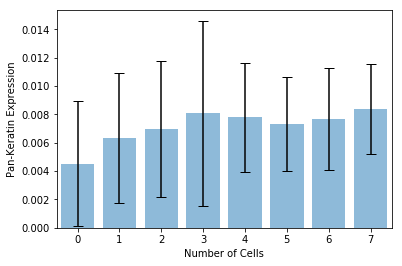

In [15]:
n_max = np.max(cell_num)
x_mean = np.zeros(n_max)
x_std = np.zeros(n_max)
for k in range(1, n_max+1):
    exp_k = []
    for i in range(len(cell_num)):
        if cell_num[i]==k:
            # print(k)
            exp_k.append(tumor_expression[i])
    x_mean[k-1] = np.mean(exp_k)
    x_std[k-1] = np.std(exp_k)


t = np.arange(n_max)
plt.xlabel('Number of Cells')
plt.ylabel('Pan-Keratin Expression')
plt.bar(t,x_mean, yerr=x_std, align='center', alpha=0.5, ecolor='black', capsize=5)
plt.xlim(-0.5, 7.5)
plt.show()

In [16]:
# CD8 Test
noise = 0.5 * torch.randn(1, 128).cuda()
total = 0
decrease = 0


cell_num = []
tumor_expression = []

for c in range(len(cells_seg_list)):
    seg_list = cells_seg_list[c]
    real_list = cells_real_list[c]
    n_cell = len(seg_list)
    
    for k in range(1, n_cell):
    
        seg_tumor = np.sum(seg_list[0], axis=0)
        seg_test = np.zeros([17, 64, 64])
        seg_test[4] = seg_tumor    # tumor
        
        seg_cd3 = 0
        if k>0:
            seg_cd3 = np.sum(seg_list[1:k+1], axis=0).sum(0)
            seg_test[4] += seg_cd3    # cd8
        
        
        
        empty = np.less(np.sum(seg_test, axis=0, keepdims=True), 0.5).astype(np.float32)
        seg_test_18 = np.concatenate([seg_test, empty], axis=0)
        X_seg_0 = torch.Tensor(seg_test_18).unsqueeze(0).cuda()

        fake = netG_A(X_seg_0).detach().cpu().numpy()[0]
        
        pk_cur = (fake[0]*seg_tumor).sum()/seg_tumor.sum()
        
        cell_num.append(k)
        tumor_expression.append(pk_cur)
        

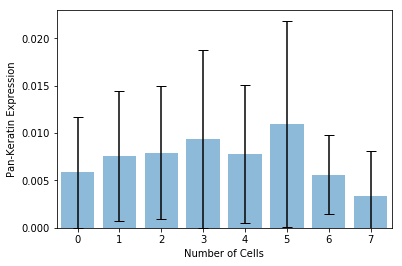

In [17]:
n_max = np.max(cell_num)
x_mean = np.zeros(n_max)
x_std = np.zeros(n_max)
for k in range(1, n_max+1):
    exp_k = []
    for i in range(len(cell_num)):
        if cell_num[i]==k:
            # print(k)
            exp_k.append(tumor_expression[i])
    x_mean[k-1] = np.mean(exp_k)
    x_std[k-1] = np.std(exp_k)


t = np.arange(n_max)
plt.xlabel('Number of Cells')
plt.ylabel('Pan-Keratin Expression')
plt.bar(t,x_mean, yerr=x_std, align='center', alpha=0.5, ecolor='black', capsize=5)
plt.xlim(-0.5, 7.5)
plt.ylim(0)
plt.show()